# Importação das bibliotecas necessárias


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
#Importando os dados
data = pd.read_csv("dados_classificados.csv")
data.sample(5)

,ID,DATA,TITULO,EMPRESA,LOCAL,LINK,DESCRICAO,RELEVANCIA
375,staff-react-native-engineer-poatek-brazil-appl...,2023-07-11,Staff React Native Engineer (Poatek- Brazil ap...,WillowTree,"Porto Alegre, RS",https://br.linkedin.com/jobs/view/staff-react-...,"Staff React Native Engineer\n\nSão Paulo-SP, B...",0
335,senior-analyst-supply-analytics-team-bangkok-b...,2023-07-11,"Senior Analyst (Supply Analytics team, Bangkok...",Agoda,"Brasília, DF",https://br.linkedin.com/jobs/view/senior-analy...,About Agoda\n\nAgoda is an online travel booki...,0
277,t%C3%A9cnico-de-seguran%C3%A7a-do-trabalho-pl-...,2023-07-11,TÉCNICO DE SEGURANÇA DO TRABALHO PL - Curitiba/PR,3778,"Curitiba, PR",https://br.linkedin.com/jobs/view/t%C3%A9cnico...,A 3778 é uma HealthTech de tecnologia que está...,0
314,pessoa-desenvolvedora-oracle-s%C3%AAnior-at-yd...,2023-07-11,PESSOA DESENVOLVEDORA ORACLE SÊNIOR,YDUQS,"Rio de Janeiro, RJ",https://br.linkedin.com/jobs/view/pessoa-desen...,AQUI SUA CARREIRA COMEÇA GRANDE.\n\nVENHA SER ...,0
203,associate-managing-consultant-advisors-client-...,2023-07-11,"Associate Managing Consultant, Advisors Client...",Mastercard,"São Paulo, SP",https://br.linkedin.com/jobs/view/associate-ma...,Our Purpose\n\nWe work to connect and power an...,1


# EDA

Vamos agora verificar quais são as maiores ocorrências na coluna TITULO

In [3]:
# Contar a ocorrência de cada título
title_occurrence = data['TITULO'].value_counts()

# Filtrar os títulos que aparecem mais de 3 vezes
filtered_titles = title_occurrence[title_occurrence > 3]

# Criar um DataFrame com os títulos e suas ocorrências
table_duplicates = pd.DataFrame({'Título': filtered_titles.index, 'Ocorrência': filtered_titles.values})

# Exibir a tabela na tela
print(table_duplicates)

                                               Título  Ocorrência
0   Chief Product and Technology Officer, gt.schoo...          12
1   Chief Product Officer, gt.school (Remote) - $8...          12
2   Manager, Search Engine Optimization (SEO) – Ba...          11
3                         Remote Ad Optimizer - LATAM          11
4   Part-Time Personalized Internet Ads Assessor -...          11
5   Manager, Marketing Strategy & Analytics (Bangk...          11
6   Analytical roles – Analyst/ Senior Analyst/ As...          11
7   Senior Analyst (Supply Analytics team, Bangkok...          11
8   Associate Manager, Marketing Strategy & Analyt...          11
9   Senior Manager – Marketing Strategies and Anal...          11
10  Chief Technology Officer, gt.school (Remote) -...           9
11  Part-Time Personalized Internet Ads Assessor -...           8
12                 Ubuntu Quality Engineering Manager           7
13                          Cientista de Dados Sênior           6
14        

É notável que apesar de que as linhas não são duplicadas, varias posições são duplicadas, porém anunciadas em cidades diferentes. No tratamento de variáveis vamos removê-las, e manter apenas uma ocorrência.

## Feature Engineering

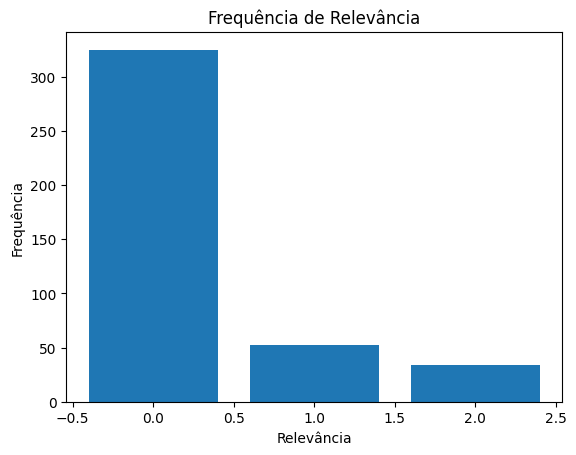

In [4]:
# Contar a frequência de cada valor na coluna "RELEVANCIA"
relevancia_counts = data['RELEVANCIA'].value_counts()

# Criar o gráfico de barras
plt.bar(relevancia_counts.index, relevancia_counts.values)

# Adicionar rótulos e título ao gráfico
plt.xlabel('Relevância')
plt.ylabel('Frequência')
plt.title('Frequência de Relevância')

# Exibir o gráfico
plt.show()

Os dados estão muito desbalanceados, como o volume de dados não é muito grande, vamos fazer algumas adaptações. Primeiro, vamos juntar todos os valores 2 com 1. Perderemos algumas informações, mas será valioso para nosso processo de treinamento do modelo

In [5]:
# Substituir os valores iguais a 2 por 1 na coluna "RELEVANCIA"
data['RELEVANCIA'] = data['RELEVANCIA'].replace(2, 1)

Assim:

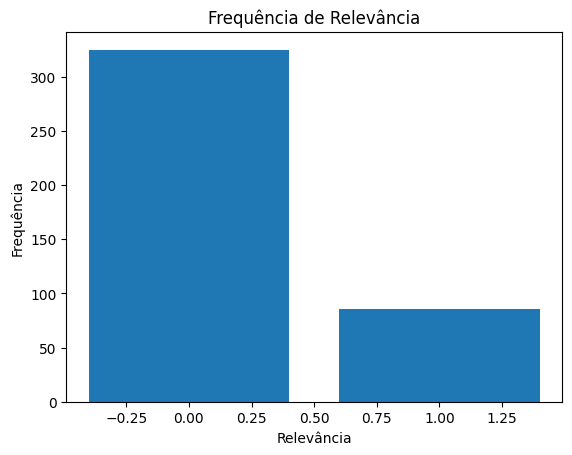

In [6]:
# Contar a frequência de cada valor na coluna "RELEVANCIA"
relevancia_counts = data['RELEVANCIA'].value_counts()

# Criar o gráfico de barras
plt.bar(relevancia_counts.index, relevancia_counts.values)

# Adicionar rótulos e título ao gráfico
plt.xlabel('Relevância')
plt.ylabel('Frequência')
plt.title('Frequência de Relevância')

# Exibir o gráfico
plt.show()

Os dados ainda estão desbalanceados, mas já é melhor do que antes. Agora vamos dividir os dados em treino e teste para continuar o feature engineering.

In [7]:
# Dividir os dados em atributos (X) e rótulos (y)
X = data.drop('RELEVANCIA', axis=1)  # Supondo que a coluna "RELEVANCIA" seja o rótulo
y = data['RELEVANCIA']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibir os tamanhos dos conjuntos de treinamento e teste
print("Tamanho do conjunto de treinamento:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))

Tamanho do conjunto de treinamento: 328
Tamanho do conjunto de teste: 83


In [8]:
# Filtrar os títulos que possuem ocorrência maior ou igual a 7
titles_to_remove = table_duplicates[table_duplicates['Ocorrência'] >= 7]['Título'].tolist()

# Exibir a lista de títulos
print(titles_to_remove)


['Chief Product and Technology Officer, gt.school (Remote) - $800,000/year USD', 'Chief Product Officer, gt.school (Remote) - $800,000/year USD', 'Manager, Search Engine Optimization (SEO) – Bangkok Based, Relocation Provided', 'Remote Ad Optimizer - LATAM', 'Part-Time Personalized Internet Ads Assessor - German Speakers in Brazil', 'Manager, Marketing Strategy & Analytics (Bangkok-based, relocation provided)', 'Analytical roles – Analyst/ Senior Analyst/ Associate Manager (Bangkok Based, Relocation Provided)', 'Senior Analyst (Supply Analytics team, Bangkok-based, Relocation provided)', 'Associate Manager, Marketing Strategy & Analytics (Bangkok-based, relocation provided)', 'Senior Manager – Marketing Strategies and Analytics (Bangkok-based, relocation provided)', 'Chief Technology Officer, gt.school (Remote) - $800,000/year USD', 'Part-Time Personalized Internet Ads Assessor - Dutch Speakers in Brazil', 'Ubuntu Quality Engineering Manager']


In [9]:
# Juntar X_train e y_train em um único DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Juntar X_test e y_test em um único DataFrame
test_data = pd.concat([X_test, y_test], axis=1)

# Remover as linhas correspondentes nos conjuntos de treinamento
train_data = train_data[~(train_data['TITULO'].isin(titles_to_remove) & train_data.duplicated(subset='TITULO', keep='first'))]

# Remover as linhas correspondentes nos conjuntos de teste
test_data = test_data[~(test_data['TITULO'].isin(titles_to_remove) & test_data.duplicated(subset='TITULO', keep='first'))]

# Separar novamente X_train, y_train, X_test e y_test
X_train = train_data.drop('RELEVANCIA', axis=1)
y_train = train_data['RELEVANCIA']
X_test = test_data.drop('RELEVANCIA', axis=1)
y_test = test_data['RELEVANCIA']

# Exibir os tamanhos dos conjuntos de treinamento e teste após a remoção
print("Tamanho do conjunto de treinamento após a remoção:", len(X_train))
print("Tamanho do conjunto de teste após a remoção:", len(X_test))


Tamanho do conjunto de treinamento após a remoção: 232
Tamanho do conjunto de teste após a remoção: 67


## Tratamento textual

Iremos juntar o texto do titulo com a descrição, em uma nova coluna "TEXT"

In [10]:
# Juntar as colunas "DESCRICAO", "TITULO", "LOCAL" e "EMPRESA" em uma nova coluna "TEXT" no conjunto de treinamento
X_train['TEXT'] = X_train['LOCAL'] + ' ' + X_train['EMPRESA'] + ' ' + X_train['TITULO'] + ' ' + X_train['DESCRICAO'] 

# Juntar as colunas "DESCRICAO", "TITULO", "LOCAL" e "EMPRESA" em uma nova coluna "TEXT" no conjunto de teste
X_test['TEXT'] = X_test['LOCAL'] + ' ' + X_test['EMPRESA'] + ' ' + X_test['TITULO'] + ' ' + X_test['DESCRICAO']

# Exibir as primeiras linhas dos conjuntos de treinamento e teste com a nova coluna "TEXT"
print("Conjunto de treinamento:")
print(X_train.head())
print()
print("Conjunto de teste:")
print(X_test.head())


Conjunto de treinamento:
                                                    ID        DATA  \
167  online-growth-vice-president-at-frubana-361057...  2023-07-11   
379  senior-manager-%E2%80%93-marketing-strategies-...  2023-07-11   
140  analista-de-business-intelligence-sr-log%C3%AD...  2023-07-11   
124  chief-product-officer-gt-school-remote-%24800-...  2023-07-11   
3    pessoa-engenheira-de-dados-junior-at-clickbus-...  2023-07-11   

                                                TITULO    EMPRESA  \
167                       Online Growth Vice President    Frubana   
379  Senior Manager – Marketing Strategies and Anal...      Agoda   
140   Analista de Business Intelligence SR - Logística  Grupo Nós   
124  Chief Product Officer, gt.school (Remote) - $8...  Crossover   
3                    PESSOA ENGENHEIRA DE DADOS JUNIOR   ClickBus   

              LOCAL                                               LINK  \
167   São Paulo, SP  https://br.linkedin.com/jobs/view/online-gro

In [11]:
# Manter apenas a coluna "TEXT" no conjunto de treinamento
X_train = X_train[['TEXT']]

# Manter apenas a coluna "TEXT" no conjunto de teste
X_test = X_test[['TEXT']]

# Exibir as primeiras linhas dos conjuntos de treinamento e teste
print("Conjunto de treinamento:")
print(X_train.head())
print()
print("Conjunto de teste:")
print(X_test.head())


Conjunto de treinamento:
                                                  TEXT
167  São Paulo, SP Frubana Online Growth Vice Presi...
379  Belém e Região Agoda Senior Manager – Marketin...
140  Cajamar, SP Grupo Nós Analista de Business Int...
124  Manaus, AM Crossover Chief Product Officer, gt...
3    Brasil ClickBus PESSOA ENGENHEIRA DE DADOS JUN...

Conjunto de teste:
                                                  TEXT
173  São Paulo, SP Núclea Analista BI Sr - Vaga afi...
33   São Paulo, Brasil dunnhumby Senior Applied Dat...
70   São Paulo, SP Hypera ARQUITETO DADOS Buscamos ...
362  Fortaleza, CE Agoda Associate Manager, Marketi...
82   São Paulo, SP PicPay Gerente de Crédito Sênior...


### Removendo stopwords e pontuações

In [15]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stopwords
from spacy.lang.pt.stop_words import STOP_WORDS as pt_stopwords
from string import punctuation

# Carregar os modelos linguísticos
nlp_en = spacy.load('en_core_web_sm')
nlp_pt = spacy.load('pt_core_news_sm')

# Função para remover stopwords e pontuações de um texto
def remove_stopwords_punctuations(text):
    doc = nlp_en(text)
    tokens = [token.text.lower() for token in doc if token.text.lower() not in en_stopwords and token.text.lower() not in pt_stopwords and token.text not in punctuation]
    return ' '.join(tokens)

# Remover stopwords e pontuações do conjunto de treinamento
X_train['TEXT'] = X_train['TEXT'].apply(remove_stopwords_punctuations)

# Remover stopwords e pontuações do conjunto de teste
X_test['TEXT'] = X_test['TEXT'].apply(remove_stopwords_punctuations)

# Exibir as primeiras linhas dos conjuntos de treinamento e teste após a remoção
print("Conjunto de treinamento:")
print(X_train.head())
print()
print("Conjunto de teste:")
print(X_test.head())


Conjunto de treinamento:
                                                  TEXT
167  paulo sp frubana online growth vice president ...
379  belém região agoda senior manager – marketing ...
140  cajamar sp analista business intelligence sr l...
124  manaus crossover chief product officer gt.scho...
3    brasil clickbus pessoa engenheira dados junior...

Conjunto de teste:
                                                  TEXT
173  paulo sp núclea analista bi sr vaga afirmativa...
33   paulo brasil dunnhumby senior applied data sci...
70   paulo sp hypera arquiteto dados buscamos talen...
362  fortaleza ce agoda associate manager marketing...
82   paulo sp picpay gerente crédito sênior modelag...


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Criar um vetorizador TF-IDF
vectorizer = TfidfVectorizer()

# Transformar os dados de texto em vetores TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train['TEXT'])
X_test_tfidf = vectorizer.transform(X_test['TEXT'])

# Inicializar o classificador Random Forest
clf = RandomForestClassifier(random_state=42)

# Treinar o classificador usando o conjunto de treinamento vetorizado
clf.fit(X_train_tfidf, y_train)

# Fazer previsões no conjunto de teste vetorizado
y_pred = clf.predict(X_test_tfidf)

# Avaliar o desempenho do modelo
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.68      0.95      0.79        42
           1       0.75      0.24      0.36        25

    accuracy                           0.69        67
   macro avg       0.71      0.60      0.58        67
weighted avg       0.70      0.69      0.63        67



In [23]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Converter os dados de treinamento e teste em uma matriz DMatrix para uso com o XGBoost
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

# Definir os parâmetros do modelo XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'seed': 42
}

# Treinar o modelo XGBoost
model = xgb.train(params, dtrain)

# Fazer previsões no conjunto de teste
y_pred = model.predict(dtest)
y_pred = (y_pred > 0.5).astype(int)

# Avaliar o desempenho do modelo
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.81      0.93      0.87        42
           1       0.84      0.64      0.73        25

    accuracy                           0.82        67
   macro avg       0.83      0.78      0.80        67
weighted avg       0.82      0.82      0.81        67



##### O modelo com XGBoost possui boas métricas, e será utilizado como modelo final.

In [24]:
import pickle

# Salvar o modelo em um arquivo pickle
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)